
#### IMPORT ALL NECESSARY MODULES


In [3]:

import numpy as np
%matplotlib inline 
import pandas as pd
import tensorflow as tf
from IPython.display import display, Image
import cv2
from PIL import Image
from tqdm import tqdm
from keras.applications.vgg19 import VGG19
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
data = pd.read_csv("azure.csv")

In [5]:
data['timestamp']= pd.to_datetime(data['timestamp'])

#### LOAD THE DATASET AND PLOT THE OBSERVATIONS

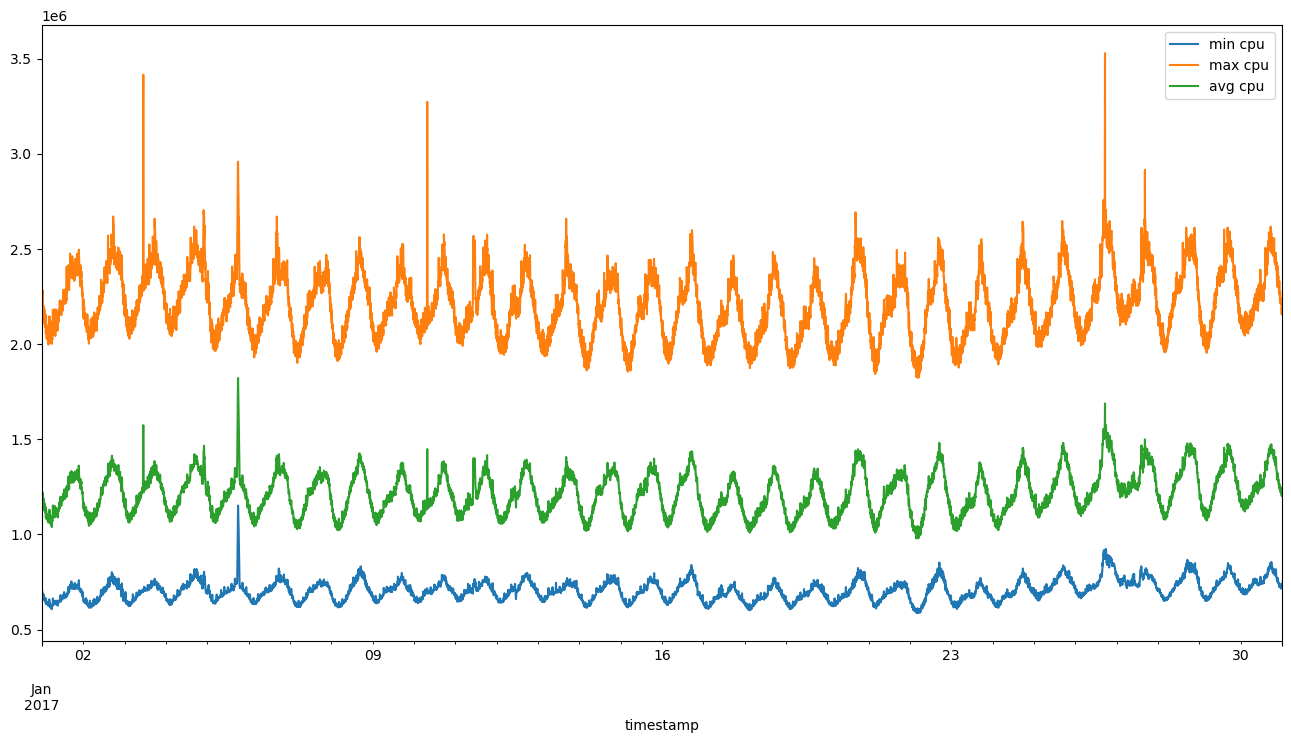

In [6]:

df = pd.read_csv('azure.csv')
df['timestamp'] =  pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
df.head()
df.plot(figsize=(16, 8))
plt.show()

In [7]:
TRAIN_LENGTH = round(len(df)*0.8)
TEST_LENGTH = len(df) - TRAIN_LENGTH
train = df.iloc[0:TRAIN_LENGTH]
test = df[TRAIN_LENGTH : ]


In [8]:
#-----------------------------------------------------------
# SCALING VALUES
#-----------------------------------------------------------
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=df.columns)
test_scaled = pd.DataFrame(scaler.transform(test), columns=df.columns)

In [9]:
#-----------------------------------------------------------
# GENERATOR TO DATA TO FEED INTO MODEL
#-----------------------------------------------------------
def train_generator(dataset, n_lags=1):
    dataX, dataY = [], []
    for i in range(len(dataset)- n_lags -1):
        a = dataset.iloc[i:(i+n_lags)].to_numpy()
        dataX.append(a)
        dataY.append(dataset.iloc[i + n_lags].to_numpy())
    return (np.array(dataX), np.array(dataY))

In [10]:
print("train_scaled columns:", train_scaled.columns)
print("test_scaled columns:", test_scaled.columns)
print("test columns:", test.columns)

train_scaled columns: Index(['min cpu', 'max cpu', 'avg cpu'], dtype='object')
test_scaled columns: Index(['min cpu', 'max cpu', 'avg cpu'], dtype='object')
test columns: Index(['min cpu', 'max cpu', 'avg cpu'], dtype='object')


In [11]:
#-----------------------------------------------------------
# DEFINING INPUTS AND EXPECTED OBSERVATIONS
#-----------------------------------------------------------
TIME_STEPS = 500
X_train, y_train = train_generator(train_scaled, n_lags = TIME_STEPS)
X_test_scaled, y_test_scaled = train_generator(test_scaled, n_lags = TIME_STEPS)
X_test, y_test = train_generator(test, n_lags = TIME_STEPS)

In [12]:
print("Shape of X_train:", X_train.shape)  # Expected: (samples, TIME_STEPS)
print("Shape of y_train:", y_train.shape)  # Expected: (samples,)

Shape of X_train: (6411, 500, 3)
Shape of y_train: (6411, 3)


In [13]:
#-----------------------------------------------------------
# USING A GRU MODEL FOR PREDICTION ON TIME SERIES
#-----------------------------------------------------------
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.GRU(512,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(tf.keras.layers.GRU(512,return_sequences=False))
model.add(tf.keras.layers.Dense(3))
model.summary()


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 500, 512)       │       794,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 512)            │     1,575,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,371,587 (9.05 MB)

 Trainable params: 2,371,587 (9.05 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Compile the model
model.compile(loss='mean_absolute_error', optimizer= tf.keras.optimizers.Adam())

In [15]:

#-----------------------------------------------------------
# DEFINING CALLBACKS
#-----------------------------------------------------------
es = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
lr_red = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=0.0000001,)

In [18]:
print("Shape of X_train:", X_train.shape)  # Should be (samples, TIME_STEPS, features)
print("Shape of y_train:", y_train.shape)  # Should be (samples,)

Shape of X_train: (6411, 500, 3)
Shape of y_train: (6411, 3)


In [20]:
callbacks = [es , lr_red]
history = model.fit(X_train, y_train, 
                    epochs=10, 
                    validation_split=0.25,
                    batch_size=512,
                    verbose=1, 
                    shuffle=False, 
                    callbacks = callbacks)

#-----------------------------------------------------------
# I TRAINED MY MODEL ON BATCHSIZES - 64,128,256
#-----------------------------------------------------------

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 224s 23s/step - loss: 0.0872 - val_loss: 0.0283 - learning_rate: 0.0010
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 190s 19s/step - loss: 0.0328 - val_loss: 0.0357 - learning_rate: 0.0010
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 198s 20s/step - loss: 0.0386 - val_loss: 0.0228 - learning_rate: 0.0010
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 195s 20s/step - loss: 0.0265 - val_loss: 0.0185 - learning_rate: 0.0010
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 212s 22s/step - loss: 0.0256 - val_loss: 0.0220 - learning_rate: 0.0010
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 204s 21s/step - loss: 0.0238 - val_loss: 0.0240 - learning_rate: 0.0010
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 205s 21s/step - loss: 0.0249 - val_loss: 0.0225 - learning_rate: 0.0010
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - loss: 0.0244 
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
10/10 ━━━━━━━━━━━━━━━━━━━━ 206s 21s/step - loss: 0.0242 - val_loss: 0.0192 - learning_r

39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 563ms/step


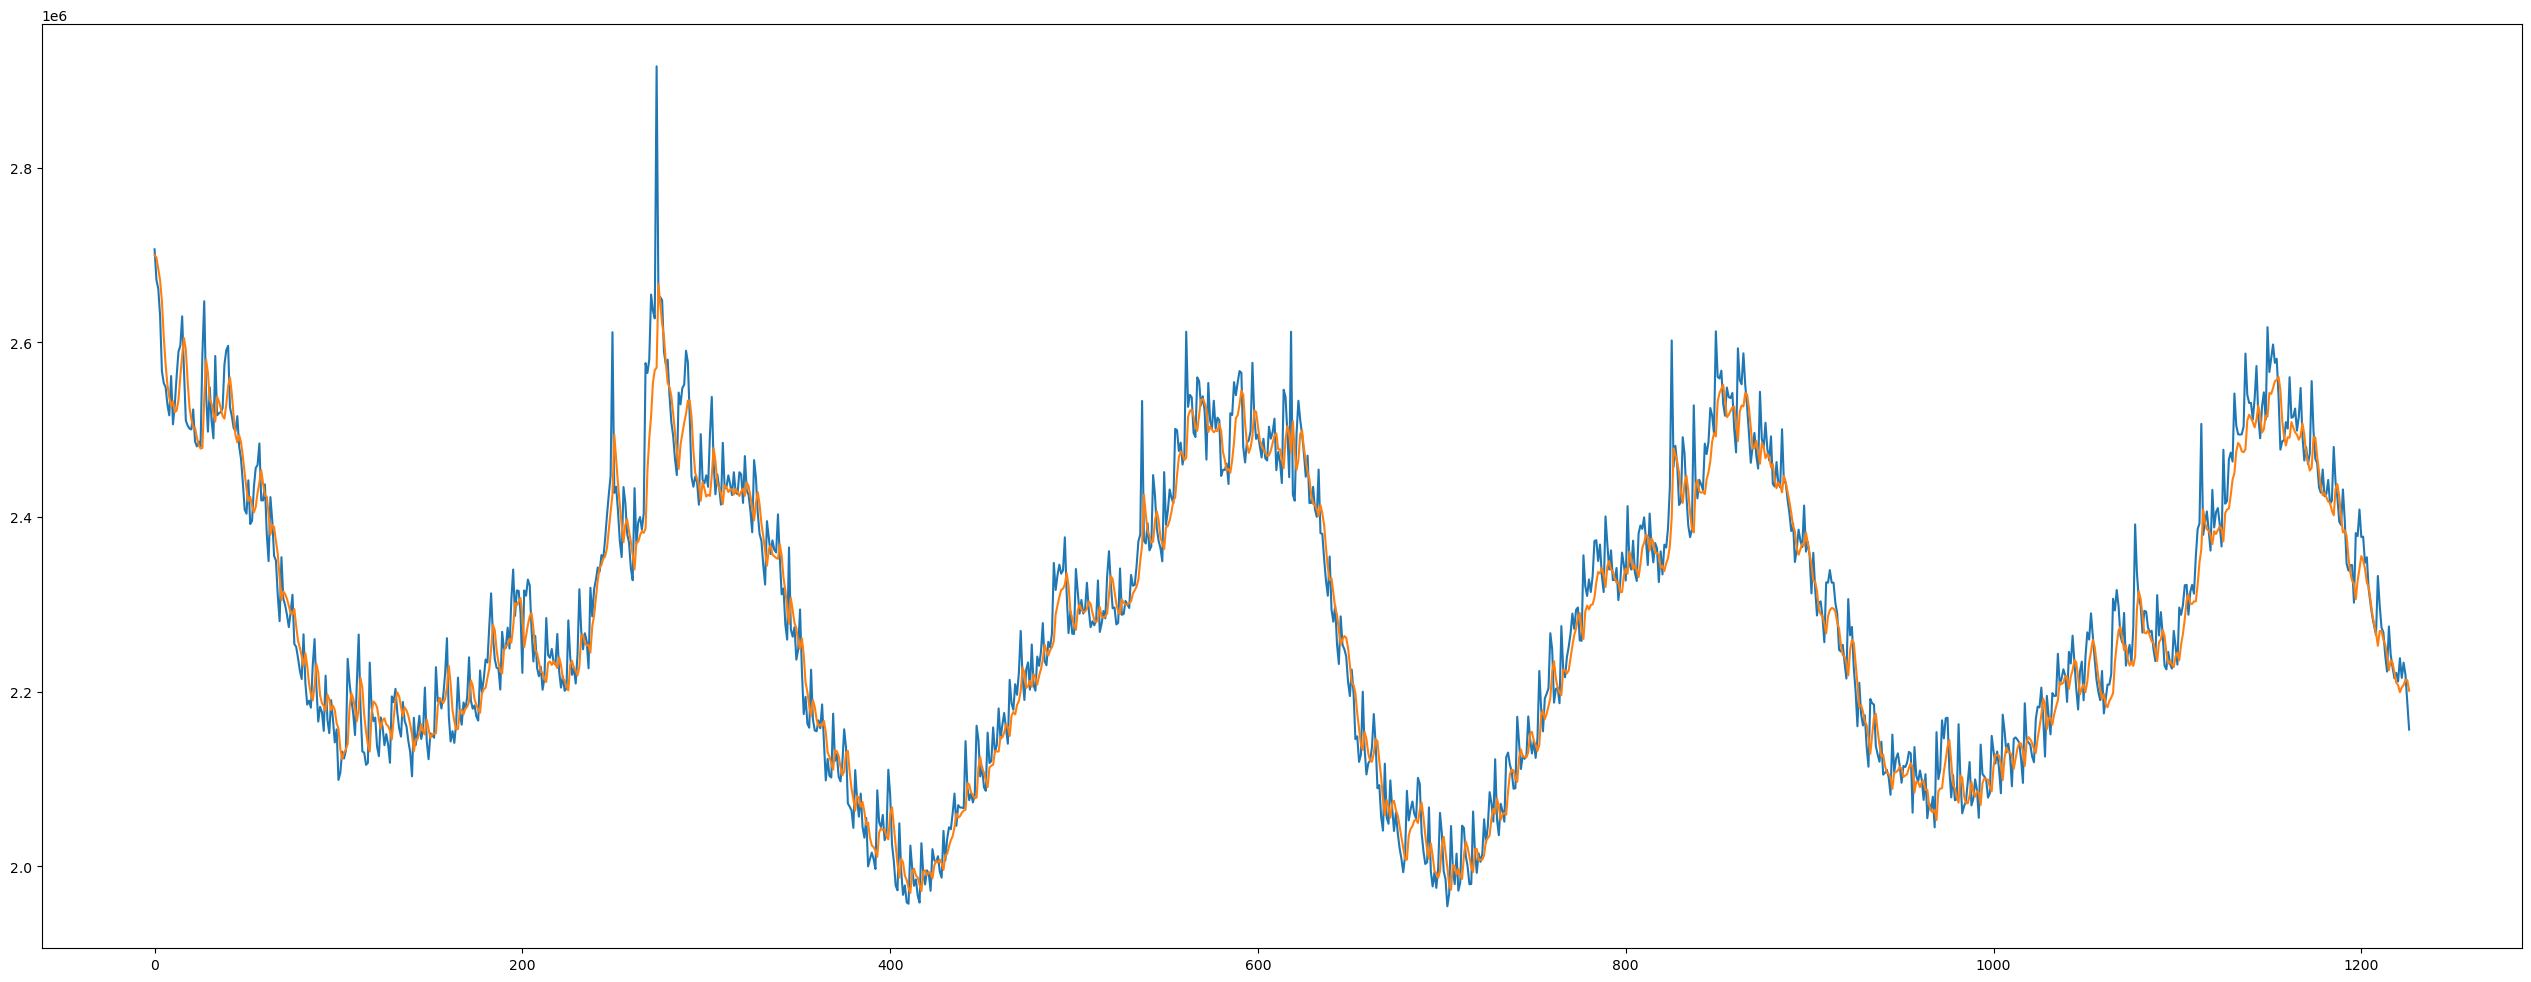

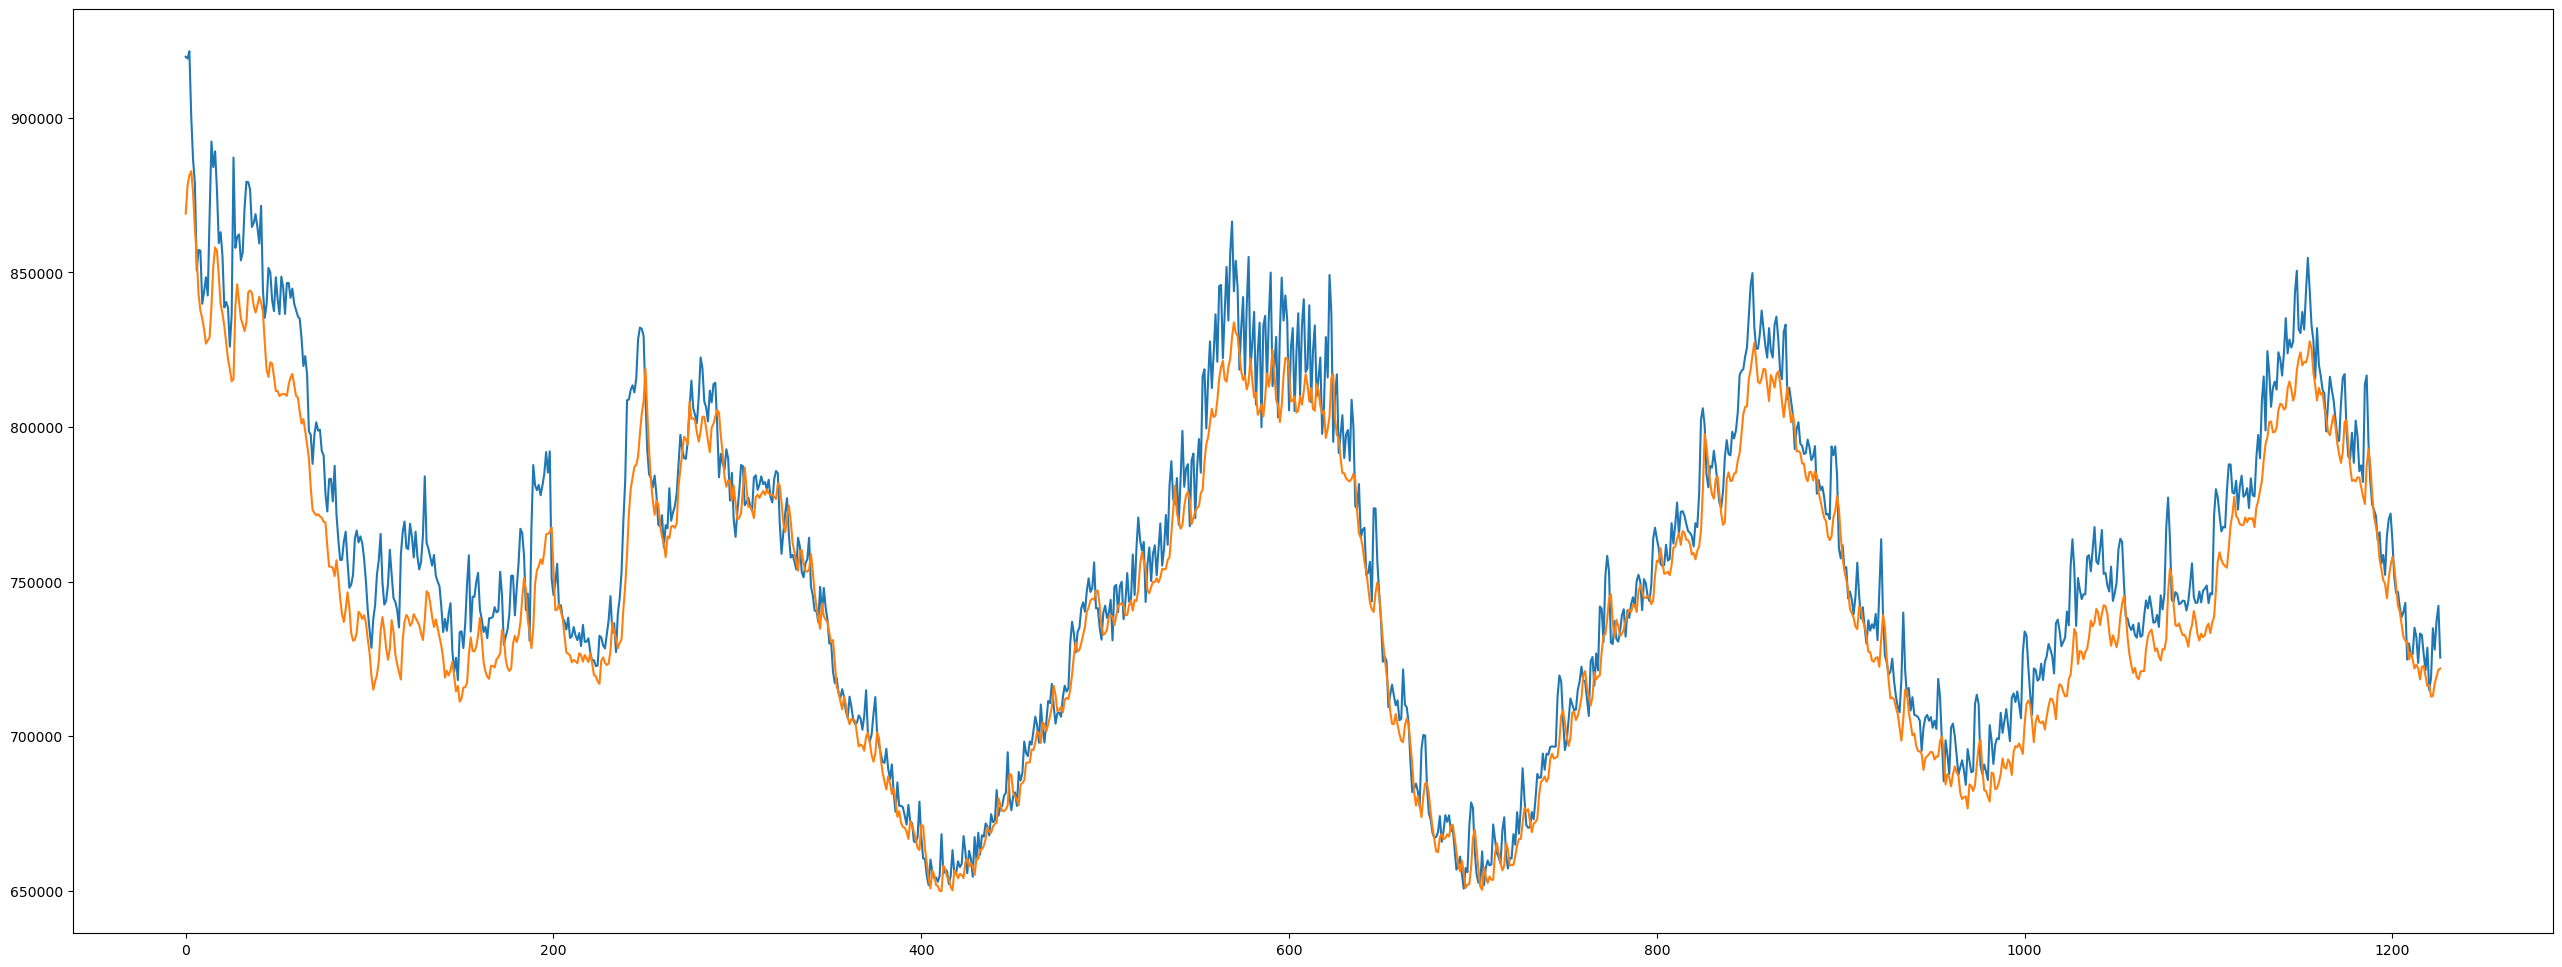

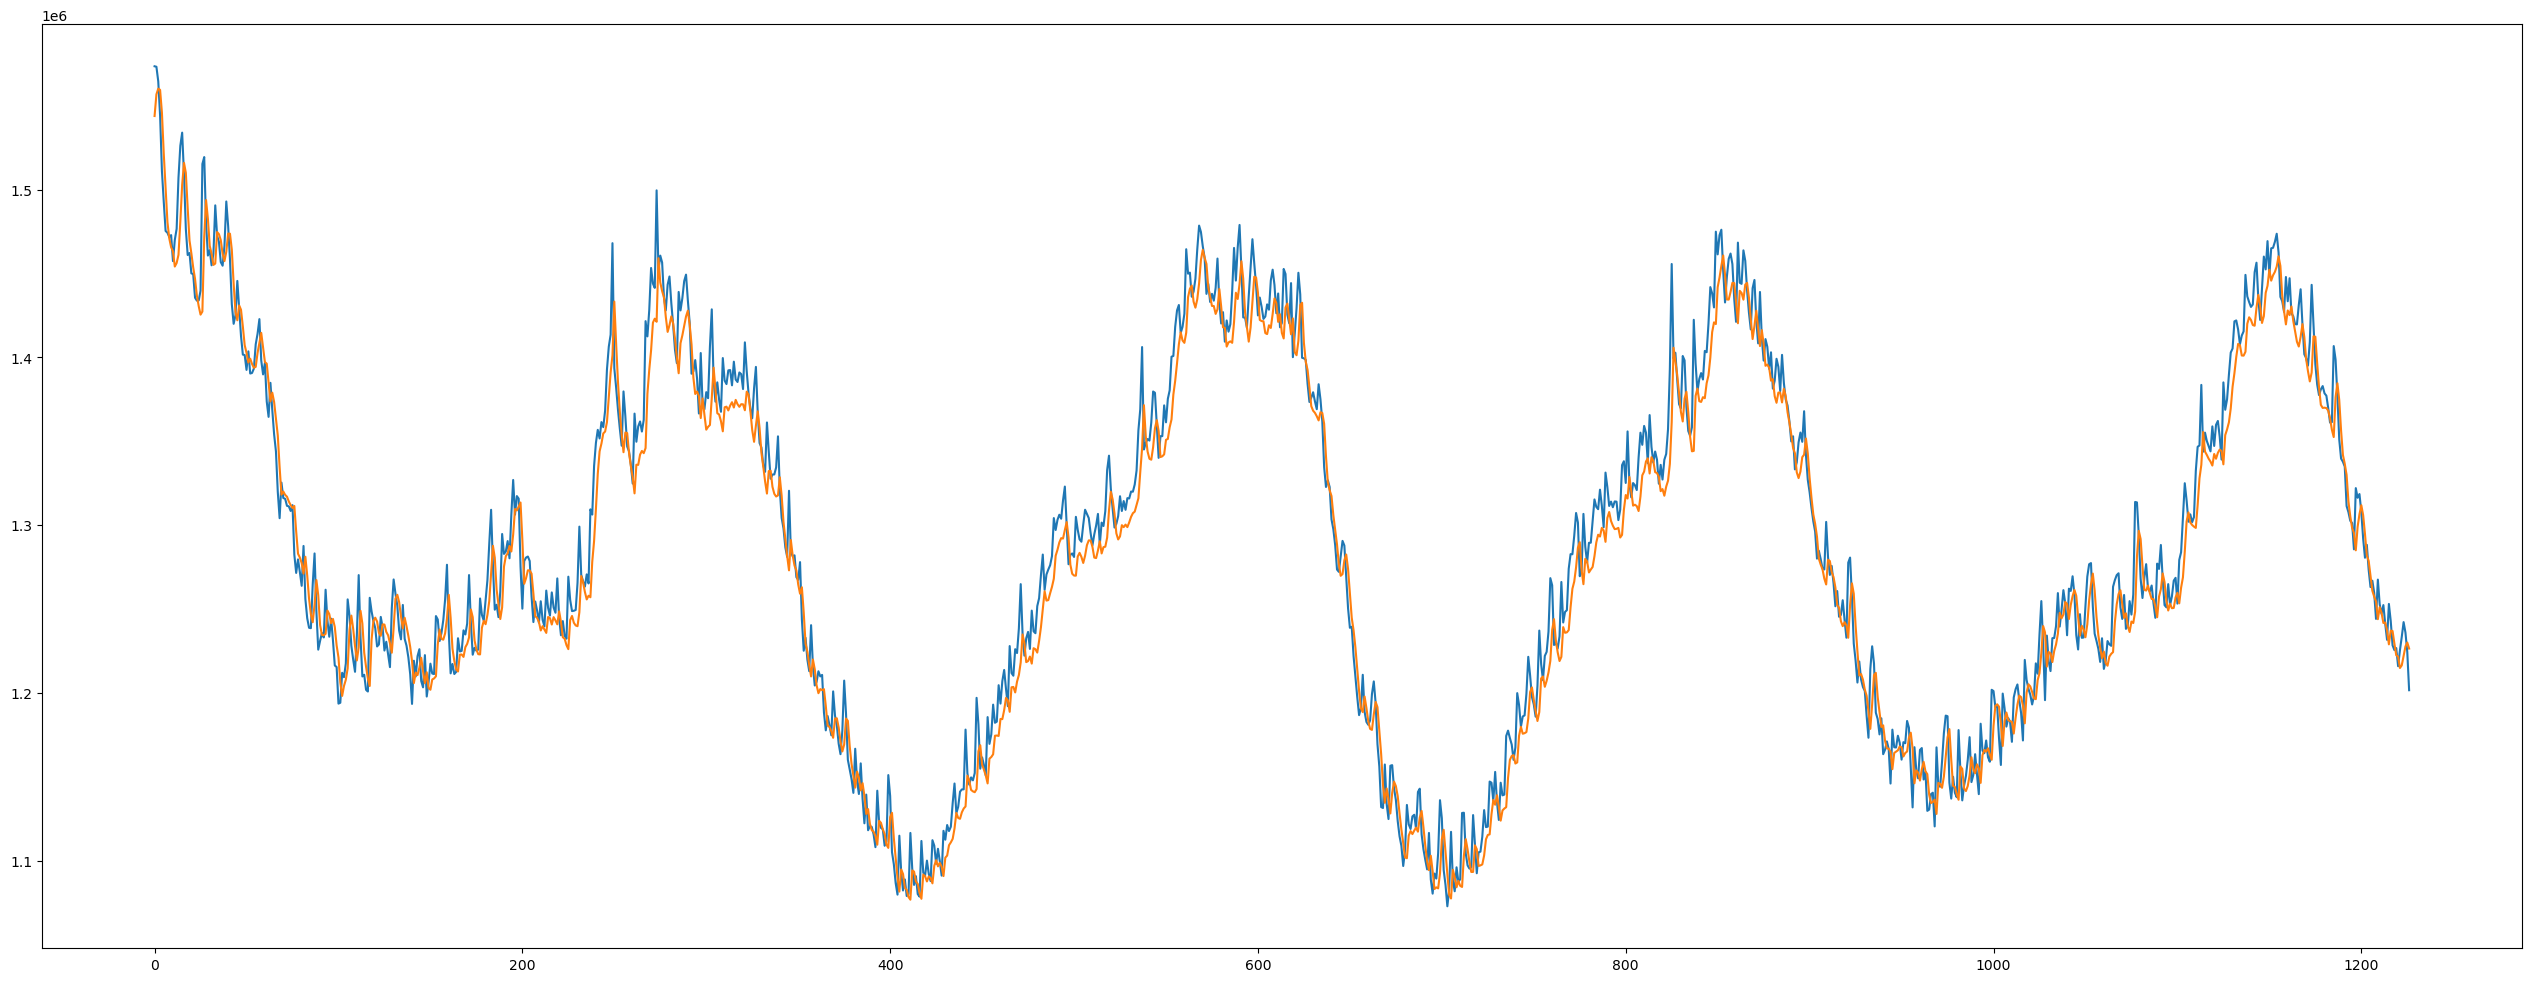

In [21]:
#-----------------------------------------------------------
# MAKING PREDICTIONS ON TEST DATA AND PLOTTING PREDICTED AND
# OBSERVED VALUES
#-----------------------------------------------------------
preds = model.predict(X_test_scaled)
preds = scaler.inverse_transform(preds)
plt.rcParams["figure.figsize"] = (32,12)
TestY= pd.DataFrame(y_test,columns=['min_cpu','max_cpu','avg_cpu'])
PredY=pd.DataFrame(preds,columns=['min_cpu','max_cpu','avg_cpu'])


plot_max = plt.figure(1)
plt.plot(TestY['max_cpu'])
plt.plot(PredY['max_cpu'])
plt.show()

plot_min = plt.figure(2)
plt.plot(TestY['min_cpu'])
plt.plot(PredY['min_cpu'])
plt.show()

plot_avg = plt.figure(3)
plt.plot(TestY['avg_cpu'])
plt.plot(PredY['avg_cpu'])
plt.show()


In [22]:
#-----------------------------------------------------------
# LETS CHECK HOW GOOD THE MODEL PERFORMED
#-----------------------------------------------------------
testScore_1 = math.sqrt(mean_squared_error(y_test[:], preds[:]))
print('Test Score: %.2f RMSE' % (testScore_1))

testScore_2 = math.sqrt(mean_absolute_error(y_test[:], preds[:]))
print('Test Score: %f MAE' % (testScore_2))

testScore_3 = np.mean(np.abs(preds - y_test)/np.abs(y_test)*100)
print('Test Score: %f MAPE' % (testScore_3))

Test Score: 26483.96 RMSE
Test Score: 135.209368 MAE
Test Score: 1.306412 MAPE
